# Movie Rating Classification using MLPClassifier, Logistic Regression, and Naive Bayes

In [1]:
#Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, 
    accuracy_score, precision_score, recall_score, 
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize


In [2]:
#Load Dataset
df = pd.read_csv('movie_ratings_dataset.csv')
print(df.shape)
df.head()


(1200, 12)


,Genre,Director_Popularity,Budget_MillionUSD,Runtime_Minutes,Release_Year,Num_Main_Actors,Avg_Actor_Popularity,Has_Famous_Producer,Num_Awards_Won,Marketing_Spend_MillionUSD,Is_Sequel,Rating_Category
0,Sci-Fi,5.80,134.63,141.0,NaN,1.0,2.72,No,9.0,25.48,No,Excellent
1,Action,2.27,220.47,98.0,2006.0,1.0,3.46,Yes,17.0,9.13,Yes,Excellent
2,Horror,1.23,52.79,160.0,2010.0,2.0,NaN,NaN,43.0,6.16,No,Excellent
3,Action,8.17,86.41,153.0,2022.0,4.0,5.21,NaN,7.0,2.99,No,Good
4,Romance,6.40,259.57,134.0,1986.0,1.0,8.72,Yes,25.0,0.89,No,Excellent


In [3]:
#Data Preprocessing
target_col = 'Rating_Category'
X = df.drop(columns=[target_col])
y = df[target_col]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Changed from 'median'
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Changed from 'constant'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


In [4]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)


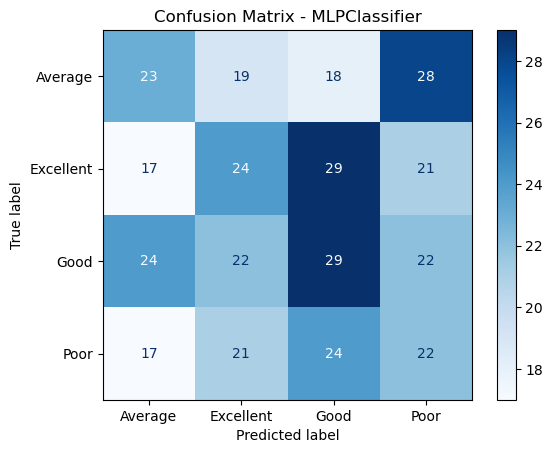

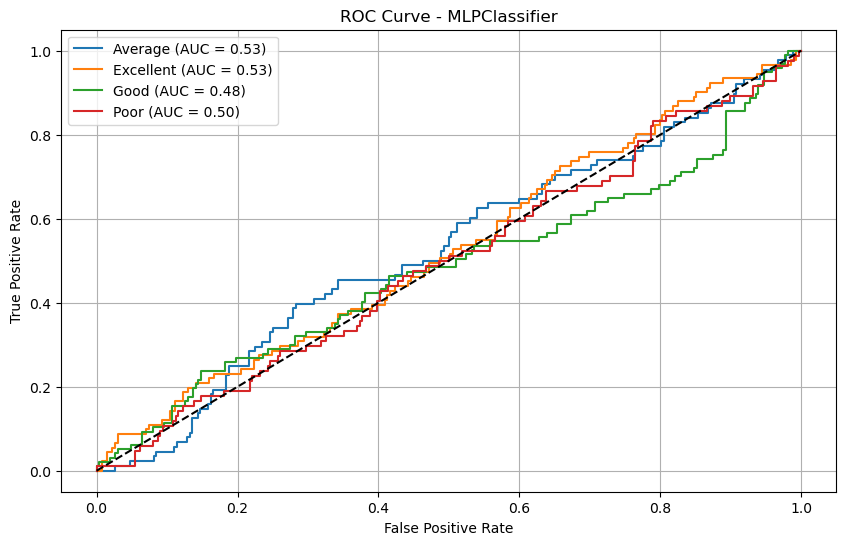

Neural Network (MLP) accuracy: 0.2722222222222222
Classification report:
              precision    recall  f1-score   support

     Average       0.28      0.26      0.27        88
   Excellent       0.28      0.26      0.27        91
        Good       0.29      0.30      0.29        97
        Poor       0.24      0.26      0.25        84

    accuracy                           0.27       360
   macro avg       0.27      0.27      0.27       360
weighted avg       0.27      0.27      0.27       360



In [5]:
#MLPClassifier
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,50), max_iter=3000, random_state=42))
])
clf.fit(X_train, y_train)
y_pred_mlp = clf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - MLPClassifier")
plt.show()

# ROC Curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
y_score = clf.predict_proba(X_test)

plt.figure(figsize=(10, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLPClassifier')
plt.legend()
plt.grid(True)
plt.show()


print("Neural Network (MLP) accuracy:", clf.score(X_test, y_test))
print("Classification report:")
print(classification_report(y_test, y_pred_mlp, target_names=label_encoder.classes_))

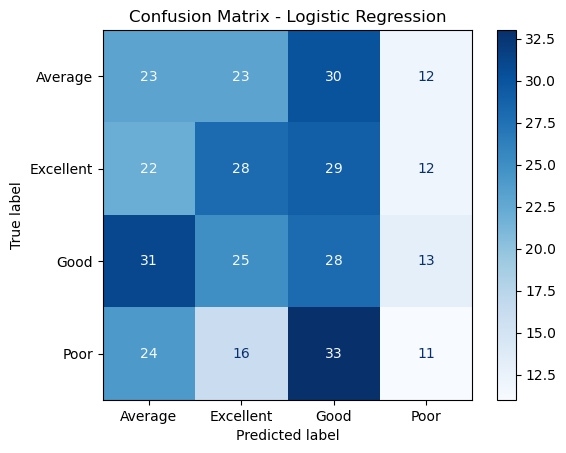

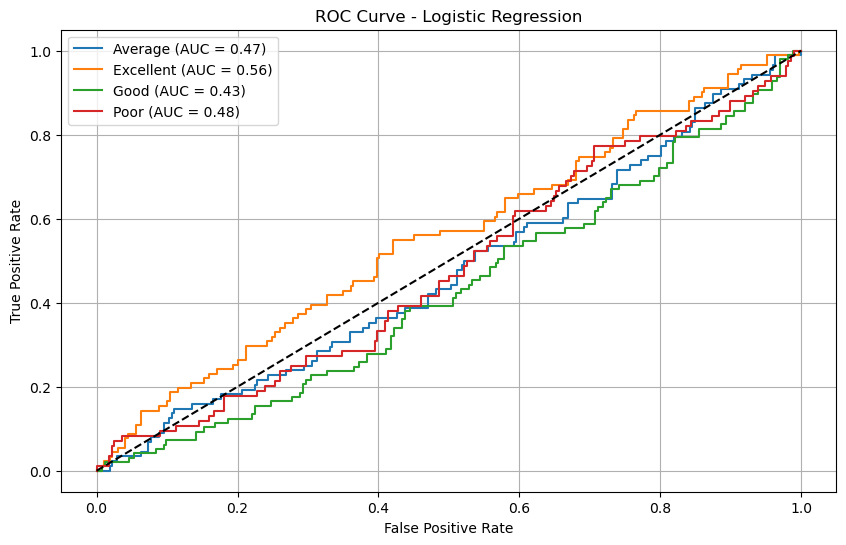

In [6]:
#Logistic Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=300, random_state=42))
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=label_encoder.classes_)
disp_lr.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ROC Curve
y_score_lr = lr_pipeline.predict_proba(X_test)
plt.figure(figsize=(10, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_lr[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_score_lr[:, i])
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()


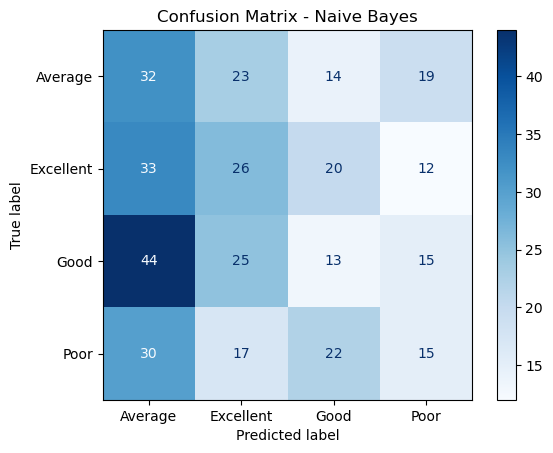

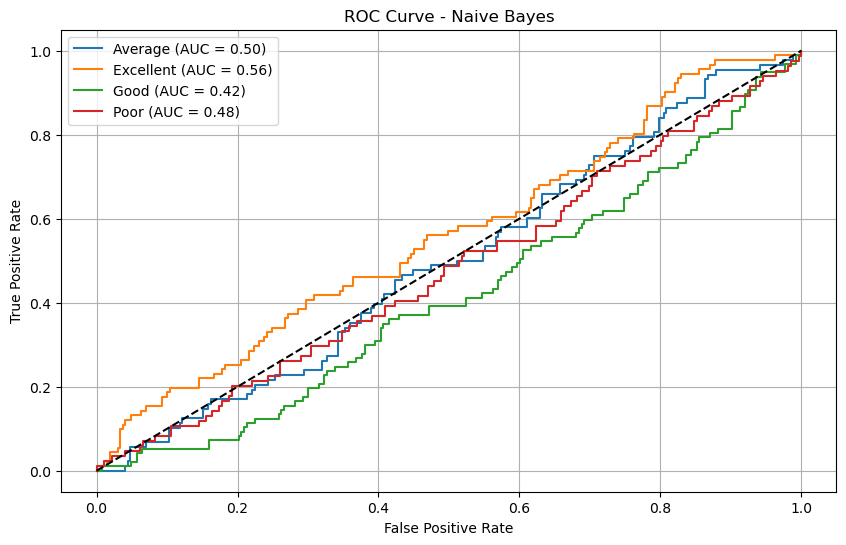

In [7]:
#Naive Bayes
nb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])
nb_pipeline.fit(X_train, y_train)
y_pred_nb = nb_pipeline.predict(X_test)

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=label_encoder.classes_)
disp_nb.plot(cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

# ROC Curve
y_score_nb = nb_pipeline.predict_proba(X_test)
plt.figure(figsize=(10, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_nb[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_score_nb[:, i])
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend()
plt.grid(True)
plt.show()


Decision Tree accuracy: 0.19166666666666668
Classification report:
              precision    recall  f1-score   support

     Average       0.17      0.16      0.17        88
   Excellent       0.20      0.21      0.20        91
        Good       0.18      0.16      0.17        97
        Poor       0.21      0.24      0.22        84

    accuracy                           0.19       360
   macro avg       0.19      0.19      0.19       360
weighted avg       0.19      0.19      0.19       360

CV scores: [0.25833333 0.2375     0.25       0.24166667 0.24166667]
Mean CV accuracy: 0.24583333333333335


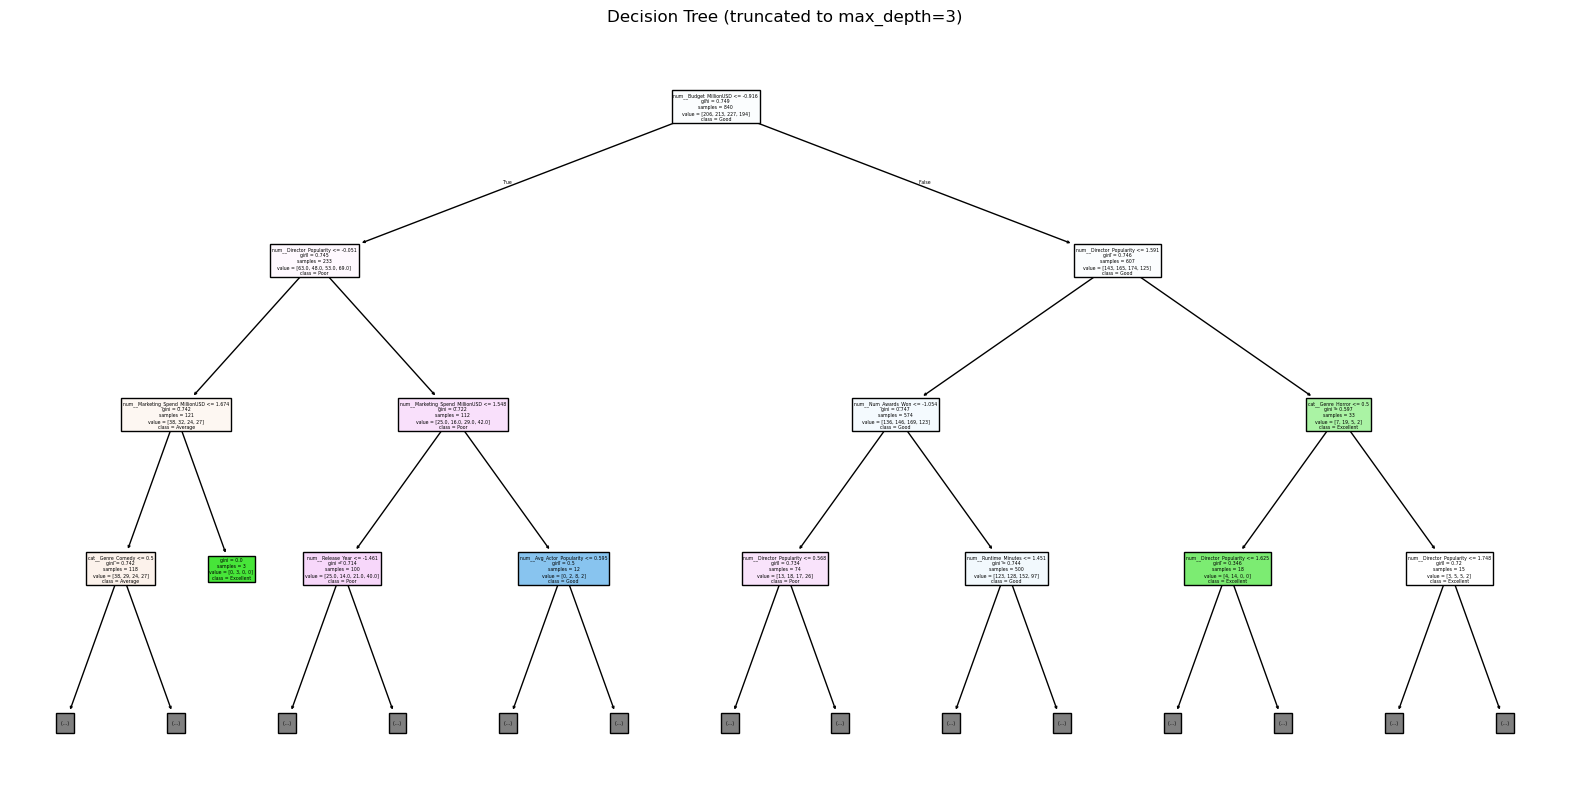

In [8]:
#Decision Tree baseline
dt_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42))
])

# Fit and evaluate
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
print("Decision Tree accuracy:", dt_clf.score(X_test, y_test))
print("Classification report:")
print(classification_report(y_test, dt_clf.predict(X_test), target_names=label_encoder.classes_))

# Cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(dt_clf, X, y_encoded, cv=5)
print("CV scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Extract the trained DecisionTreeClassifier from the pipeline
tree_model = dt_clf.named_steps['tree']

# Get feature names after preprocessing
feature_names = dt_clf.named_steps['preprocessor'].get_feature_names_out()

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=feature_names, class_names=label_encoder.classes_, filled=True, max_depth=3)
plt.title("Decision Tree (truncated to max_depth=3)")
plt.show()

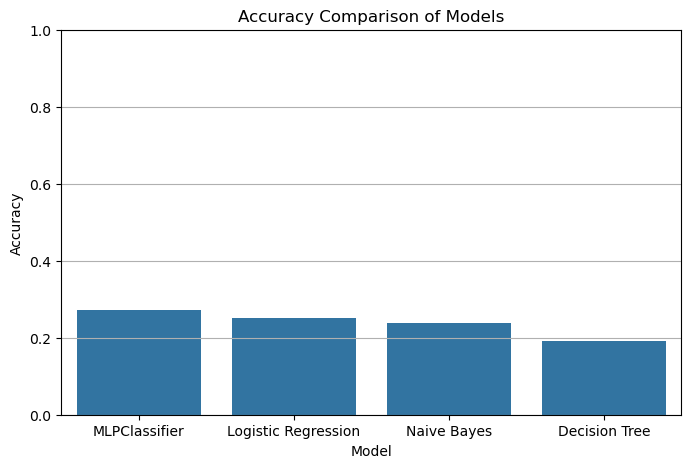

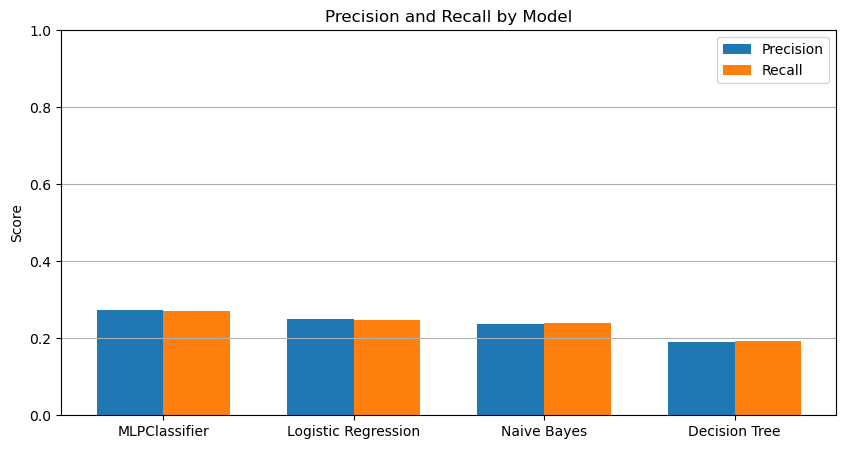

In [9]:
# Final Comparison Charts
comparison_results = {
    "Model": ["MLPClassifier", "Logistic Regression", "Naive Bayes", "Decision Tree"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_mlp),
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_dt)
    ],
    "Precision (macro)": [
        precision_score(y_test, y_pred_mlp, average='macro'),
        precision_score(y_test, y_pred_lr, average='macro'),
        precision_score(y_test, y_pred_nb, average='macro'),
        precision_score(y_test, y_pred_dt, average='macro')
    ],
    "Recall (macro)": [
        recall_score(y_test, y_pred_mlp, average='macro'),
        recall_score(y_test, y_pred_lr, average='macro'),
        recall_score(y_test, y_pred_nb, average='macro'),
        recall_score(y_test, y_pred_dt, average='macro')
    ]
}

comparison_df = pd.DataFrame(comparison_results)

# Accuracy
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Accuracy", data=comparison_df)
plt.ylim(0, 1)
plt.title("Accuracy Comparison of Models")
plt.grid(True, axis='y')
plt.show()

# Precision and Recall
x = np.arange(len(comparison_df["Model"]))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, comparison_df["Precision (macro)"], width, label='Precision')
ax.bar(x + width/2, comparison_df["Recall (macro)"], width, label='Recall')

ax.set_ylabel('Score')
ax.set_title('Precision and Recall by Model')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df["Model"])
ax.set_ylim(0, 1)
ax.legend()
plt.grid(True, axis='y')
plt.show()


In [19]:
print("Target variable distribution:")
print(y.value_counts(normalize=True))

Target variable distribution:
Rating_Category
Good         0.270000
Excellent    0.253333
Average      0.245000
Poor         0.231667
Name: proportion, dtype: float64


In [20]:
# Check numerical features
print("\nNumerical features statistics:")
print(X[numerical_cols].describe())

# Check categorical features
print("\nCategorical features distribution:")
for col in categorical_cols:
    print(f"\n{col} distribution:")
    print(X[col].value_counts(normalize=True))


Numerical features statistics:
       Director_Popularity  Budget_MillionUSD  Runtime_Minutes  Release_Year  \
count          1067.000000        1096.000000      1074.000000   1088.000000   
mean              5.452624         152.768723       129.401304   2002.330882   
std               2.600397          85.998943        28.744659     13.068670   
min               1.010000           1.040000        80.000000   1980.000000   
25%               3.310000          78.857500       103.000000   1991.000000   
50%               5.400000         156.060000       130.000000   2002.000000   
75%               7.690000         226.017500       154.000000   2014.000000   
max              10.000000         299.730000       179.000000   2024.000000   

       Num_Main_Actors  Avg_Actor_Popularity  Num_Awards_Won  \
count      1075.000000           1066.000000     1061.000000   
mean          2.531163              5.495159       24.113101   
std           1.143236              2.620555       14.4

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf_pipeline.fit(X_train, y_train)

importances = rf_pipeline.named_steps['classifier'].feature_importances_
feature_names = (
    numerical_cols +
    list(rf_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols))
)
import pandas as pd
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp)

Budget_MillionUSD             0.122430
Marketing_Spend_MillionUSD    0.116778
Director_Popularity           0.115660
Avg_Actor_Popularity          0.115132
Runtime_Minutes               0.110655
Release_Year                  0.106783
Num_Awards_Won                0.103551
Num_Main_Actors               0.046305
Genre_Horror                  0.018431
Has_Famous_Producer_No        0.018200
Is_Sequel_Yes                 0.017939
Has_Famous_Producer_Yes       0.017324
Is_Sequel_No                  0.016926
Genre_Comedy                  0.016557
Genre_Drama                   0.014839
Genre_Sci-Fi                  0.014349
Genre_Romance                 0.014320
Genre_Action                  0.013822
dtype: float64
